In [43]:
from decoder.eval_decoder import _get_models, _reconstruct_audio, _get_data, _get_all_data

# Import necessary modules
import numpy as np
import torch
import IPython.display as ipd

from config_code.config_classes import OptionsConfig
from ipywidgets import interact, FloatSlider


def create_get_options_func(nb_dims, type):
    model = f"{type}_{nb_dims}"
    if model == "SIM_32":
        from configs.sim_audio_de_boer_distr_true import _get_options
        experiment_name = "full_pipeline_bart_32_16/audio_FULL_PIPELINE_sim_de_boer_32dim_SIM=trueKLD=0.001"
    elif model == "GIM_32":  # GIM
        from configs.sim_audio_de_boer_distr_false import _get_options
        experiment_name = "full_pipeline_bart_32_16/audio_FULL_PIPELINE_sim_de_boer_32dim_SIM=falseKLD=0"
    elif model == "SIM_512":
        from configs.sim_audio_de_boer_distr_true import _get_options
        experiment_name = "full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=trueKLD=0.01"
    elif model == "GIM_512":
        from configs.sim_audio_de_boer_distr_false import _get_options
        experiment_name = "full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=falseKLD=0"
    else:
        raise ValueError(f"model: {model} not found")

    get_options = lambda: _get_options(experiment_name)
    return get_options


def plot(z, savename=""):
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()

    # display audio time series
    import matplotlib.pyplot as plt

    plt.plot(audio)
    # set x axis between 0 and 1000
    plt.ylim(-0.35, 0.35)

    if savename:
        plt.title(savename)
        plt.savefig(f"temp/pdf/audio_{savename}.pdf")
        plt.savefig(f"temp/png/audio_{savename}.png")
        # tikz
        try:
            import tikzplotlib
            tikzplotlib.save(f"temp/tex/audio_{savename}.tex")
        except ImportError:
            pass

    plt.show()

def decode_audio(z):
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()
    return audio

def audio(z):
    z_tensor = torch.from_numpy(z).float().to(opt.device)
    x_reconstructed = _reconstruct_audio(z_tensor, decoder)
    audio = x_reconstructed.squeeze().cpu().detach().numpy()

    from IPython.display import display
    display(ipd.Audio(audio, rate=16_000))


def get_two_zs(z, filenames, idx1, idx2, print_names: bool = True) -> (np.ndarray, np.ndarray, str, str):
    assert idx1 != idx2

    z = z.cpu().numpy()
    z1 = z[idx1].reshape(1, nb_dims, -1)  # (1, 32, 64)
    z2 = z[idx2].reshape(1, nb_dims, -1)  # (1, 32, 64)
    z1_file = filenames[idx1]
    z2_file = filenames[idx2]
    if print_names:
        print(z1_file, z2_file)

    if idx1 in [27, 15] and idx2 in [27, 15]:
        assert z1_file in ["bibibi_1", "bagaga_1"]
        assert z2_file in ["bibibi_1", "bagaga_1"]

    return z1, z2, z1_file, z2_file


def print_z_names(filenames):
    for i, f in enumerate(filenames):
        print(f"Idx: {i}: {f}")


def interpolate(z1, z2, nb_interpolations=10):
    vals = np.linspace(0, 1, nb_interpolations)
    z_interpolated = np.stack([z1 * val + z2 * (1 - val) for val in vals])
    return z_interpolated


def interpolate_partial(z1, z2, indices, nb_interpolations=10):
    z_interpolated = np.zeros((nb_interpolations, nb_dims, 64))
    for i in range(nb_interpolations):
        val = i / (nb_interpolations - 1)
        z_interpolated[i] = z1.copy()
        z_interpolated[i, indices] = z1[0, indices] * val + z2[0, indices] * (1 - val)
    return z_interpolated


def bar_chart(z, savename=""):
    import matplotlib.pyplot as plt
    # plot window size
    plt.figure(figsize=(26, 5))

    plt.bar(range(nb_dims), z.squeeze())

    # if no negative values:
    if np.all(z >= 0):
        pass
    else:
        # y axis between -2 and 2
        plt.ylim(-4, 4)

    plt.xlim(0, nb_dims)

    # set the resolution of the x axis
    # plt.xticks(range(nb_dims))

    if savename:
        plt.savefig(f"temp/pdf/bar_{savename}.pdf")
        plt.savefig(f"temp/png/bar_{savename}.png")
        # tikz
        try:
            import tikzplotlib
            tikzplotlib.save(f"temp/tex/bar_{savename}.tex")
        except ImportError:
            pass

    plt.show()

In [47]:
nb_dims = 512
type = "SIM"  # SET VAL TO "GIM" OR "SIM" (my technique is SIM)

get_options = create_get_options_func(nb_dims, type)
opt = get_options()
context_model, decoder = _get_models(opt)

Let's use 1 GPUs!
Loading weights from  ./sim_logs//full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=trueKLD=0.01
DataParallel(
  (module): FullModel(
    (fullmodel): ModuleList(
      (0): IndependentModule(
        (encoder): CNNEncoder(
          (encoder): Sequential(
            (layer 0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(2,))
              (1): ReLU()
            )
            (layer 1): Sequential(
              (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), padding=(2,))
              (1): ReLU()
            )
          )
          (encoder_mu): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
          (encoder_var): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
        )
        (loss): InfoNCE_Loss(
          (predictor): Linear(in_features=512, out_features=6144, bias=False)
          (loss): LogSoftmax(dim=1)
        )
      )
      (1): IndependentModule(
        (encoder): CNNEncoder(
          (encoder)

In [48]:
_, _, z, filenames = _get_all_data(opt, context_model, decoder)
nb_files = len(filenames)

Loading data... SHUFFLE IS OFF!
Loading De Boer Sounds dataset...
using reshuffledv2 directory


In [49]:
def dist_after_interpol_important_dims(z1, z2, nb_dims):
    assert nb_most_important_dims <= nb_dims

    z_1_single_timeframe = z1.mean(axis=2)  # (1, 32)
    z_2_single_timeframe = z2.mean(axis=2)  # (1, 32)
    
    # mse
    mse = (z_1_single_timeframe - z_2_single_timeframe) ** 2  
    dims = np.argsort(mse.squeeze())[::-1][:nb_dims]  # in descending order

    z2_partial = interpolate_partial(z1, z2, dims, 10)[-1] # take the most interpolated z (same as having a mask)
    # audio(z2_partial)
    # audio(z2)
    x2_partial = decode_audio(z2_partial)
    x2_target = decode_audio(z2)
    
    
    dist = np.abs(x2_partial - x2_target)
    dist = dist.mean()
    return dist

# Average error experiment
# z1, z2, z1_file, z2_file = get_two_zs(z, filenames, idx1=0, idx2=19)  # 0 = babadu_1, 19 = bagubi_1

# nb_most_important_dims = 3  # val between 1 and 512

# dist = dist_after_interpol_important_dims(z1, z2, nb_most_important_dims)
# print(f"Average error: {dist}")  # 0.0003

# iterate over pairs of z1 and z2
avg_error = 0
for nb_most_important_dims in [16, 32, 64, 128]:
    print(f"nb_most_important_dims: {nb_most_important_dims}")
    for i in range(nb_files):
        for j in range(nb_files):
            if i != j:
                z1, z2, z1_file, z2_file = get_two_zs(z, filenames, idx1=i, idx2=j, print_names=False)
                dist = dist_after_interpol_important_dims(z1, z2, nb_most_important_dims)
                avg_error += dist
                
avg_error /= (nb_files * (nb_files - 1) * 4)
print(f"Final MAX average error: {avg_error}")

# GIM; Final average error: 0.05987966596827807
# SIM: Final average error: 0.03151293721015191

# GIM: Final MAX average error: 0.06905872254599414
# SIM: Final MAX average error: 0.058209847315814064

nb_most_important_dims: 16
nb_most_important_dims: 32
nb_most_important_dims: 64
nb_most_important_dims: 128
Final MAX average error: 0.058209847315814064


In [51]:
print(f"GIM {0.05987966596827807/0.06905872254599414}")  # GIM 0.8670833134568529
print(f"SIM {0.03151293721015191/0.058209847315814064}") # SIM 0.5413678039590164

GIM 0.8670833134568529
SIM 0.5413678039590164


In [19]:
_, _, z, filenames = _get_data(opt, context_model, decoder)
print_z_names(filenames)
# z1, z2, z1_file, z2_file = get_two_zs(z, filenames, 27, 15)  # 27 = bibibi_1, 15 = bagaga_1
# z1, z2, z1_file, z2_file = get_two_zs(z, filenames, 36, 15)  # 36 = bididu_1, 15 = bagaga_1
z1, z2, z1_file, z2_file = get_two_zs(z, filenames, idx1=0, idx2=19)  # 0 = babadu_1, 19 = bagubi_1

# plot(z1)
# plot(z2)

audio(z1)
audio(z2)

Loading data... SHUFFLE IS OFF!
Loading De Boer Sounds dataset...
using reshuffledv2 directory
Idx: 0: babadu_1
Idx: 1: babagi_1
Idx: 2: babibi_1
Idx: 3: babibu_2
Idx: 4: babidi_2
Idx: 5: babiga_1
Idx: 6: babiga_2
Idx: 7: babugu_1
Idx: 8: badadi_1
Idx: 9: badidi_1
Idx: 10: badidu_1
Idx: 11: badiga_1
Idx: 12: bagaba_1
Idx: 13: bagabu_1
Idx: 14: bagada_1
Idx: 15: bagaga_1
Idx: 16: bagibi_1
Idx: 17: bagida_1
Idx: 18: bagidi_2
Idx: 19: bagubi_1
Idx: 20: bagubi_2
Idx: 21: baguda_1
Idx: 22: bagugu_1
Idx: 23: bibaba_1
Idx: 24: bibabu_1
Idx: 25: bibada_1
Idx: 26: bibadi_1
Idx: 27: bibibi_1
Idx: 28: bibibu_1
Idx: 29: bibida_1
Idx: 30: bibigu_1
Idx: 31: bibubi_2
Idx: 32: bibuda_1
Idx: 33: bibugu_1
Idx: 34: bidabi_1
Idx: 35: bidaga_1
Idx: 36: bididu_1
Idx: 37: bigabi_1
Idx: 38: bigadi_1
Idx: 39: bigaga_2
Idx: 40: bigagi_2
Idx: 41: bigidi_1
Idx: 42: bigigu_1
Idx: 43: bigubu_1
Idx: 44: biguda_1
Idx: 45: bubiba_1
Idx: 46: bubida_1
Idx: 47: bubidi_1
Idx: 48: bububa_1
Idx: 49: budabi_1
Idx: 50: budabu

In [20]:
interpolations = interpolate(z1, z2, 10)
print(f"Interpolating between {z2_file} and {z1_file}")
for z in interpolations:
    audio(z)

Interpolating between bagubi_1 and babadu_1


In [24]:
# ********************************************************************************************************************
# CHOOSE HOW MANY DIMENSIONS WILL BE CHANGED.
# PLAY AROUND WITH THIS VALUE. Observe that GIM NEEDS MORE DIMENSIONS TO CHANGE THAN SIM, implying that GIM's information is more spread out. (SIM's information is more concentrated in fewer dimensions)
nb_most_important_dims = 128  # val between 1 and 512
assert nb_most_important_dims <= nb_dims
# ********************************************************************************************************************

# mean
z_1_single_timeframe = z1.mean(axis=2)  # (1, 32)
z_2_single_timeframe = z2.mean(axis=2)  # (1, 32)
elemwise_multipl = abs(
    z_1_single_timeframe * z_2_single_timeframe)  # most important dimensions based on elementwise multiplication of z1.mean and z2.mean, where z1.ean and z2.mean are vectors of size 512 (or 32 in smaller architecture)

# mse
# elemwise_multipl = (z_1_single_timeframe - z_2_single_timeframe) ** 2  # most important dimensions based on elementwise multiplication of z1.mean and z2.mean, where z1.ean and z2.mean are vectors of size 512 (or 32 in smaller architecture)

# Objective: start from z_digibi and go to z_gabaga, but only change the 10 important dimensions (based on var: `elemwise_multipl)
# 1. get the 10 most important dimensions
dims = np.argsort(elemwise_multipl.squeeze())[::-1][:nb_most_important_dims]  # in descending order

# 2. start from z_digibi and go to z_gabaga, but only change the 10 important dimensions
zs = interpolate_partial(z1, z2, dims, 10)
print(
    f"Interpolating between {z2_file} and {z1_file} but only changing the {nb_most_important_dims} most important dimensions")
for z in zs:
    audio(z)


Interpolating between bagubi_1 and babadu_1 but only changing the 128 most important dimensions


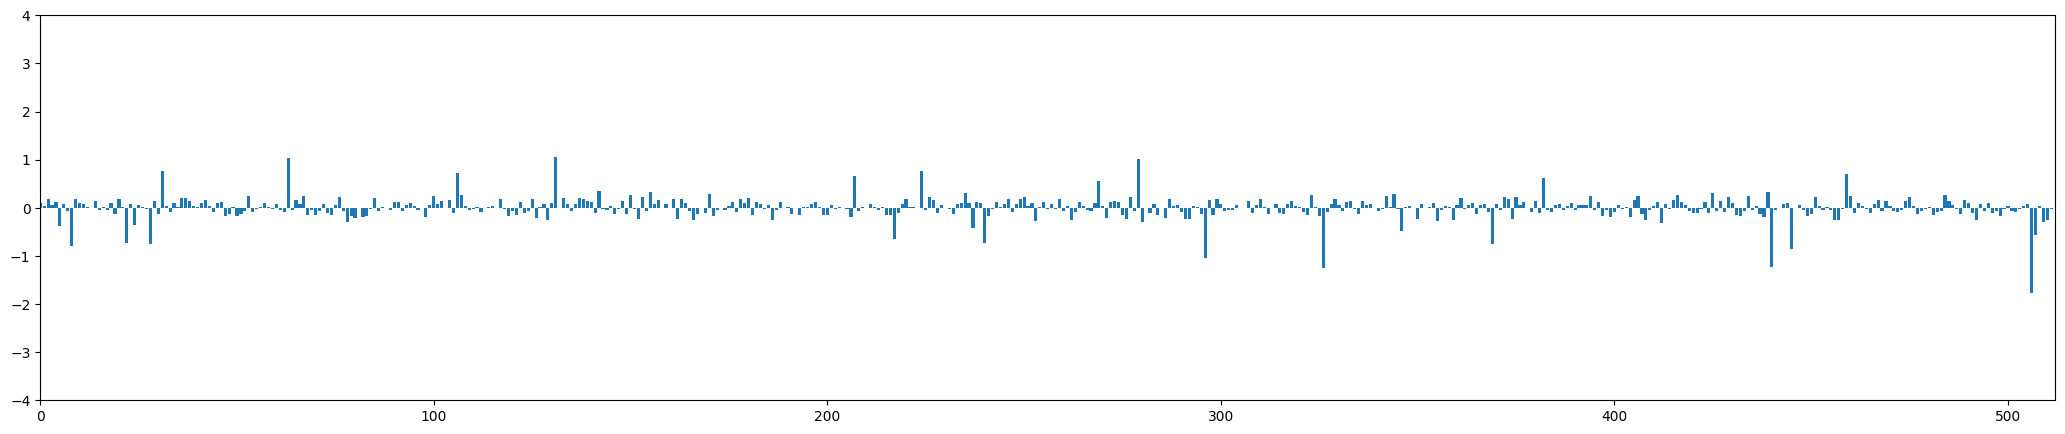

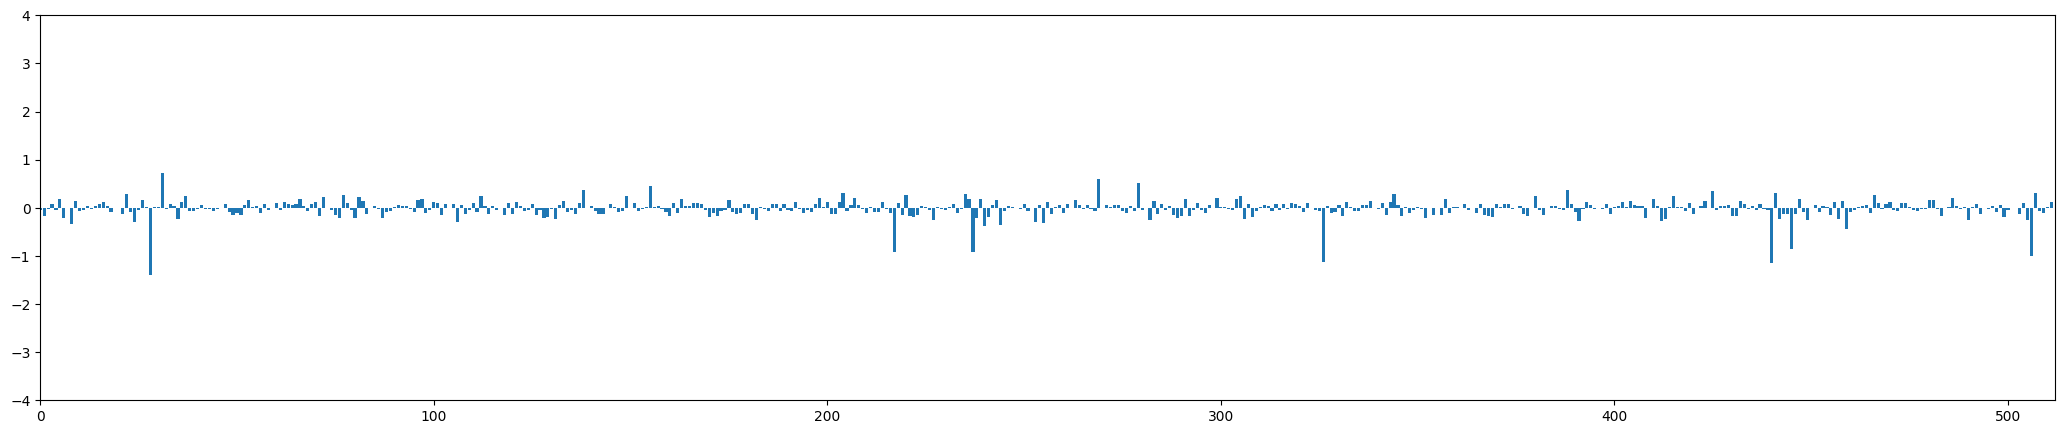

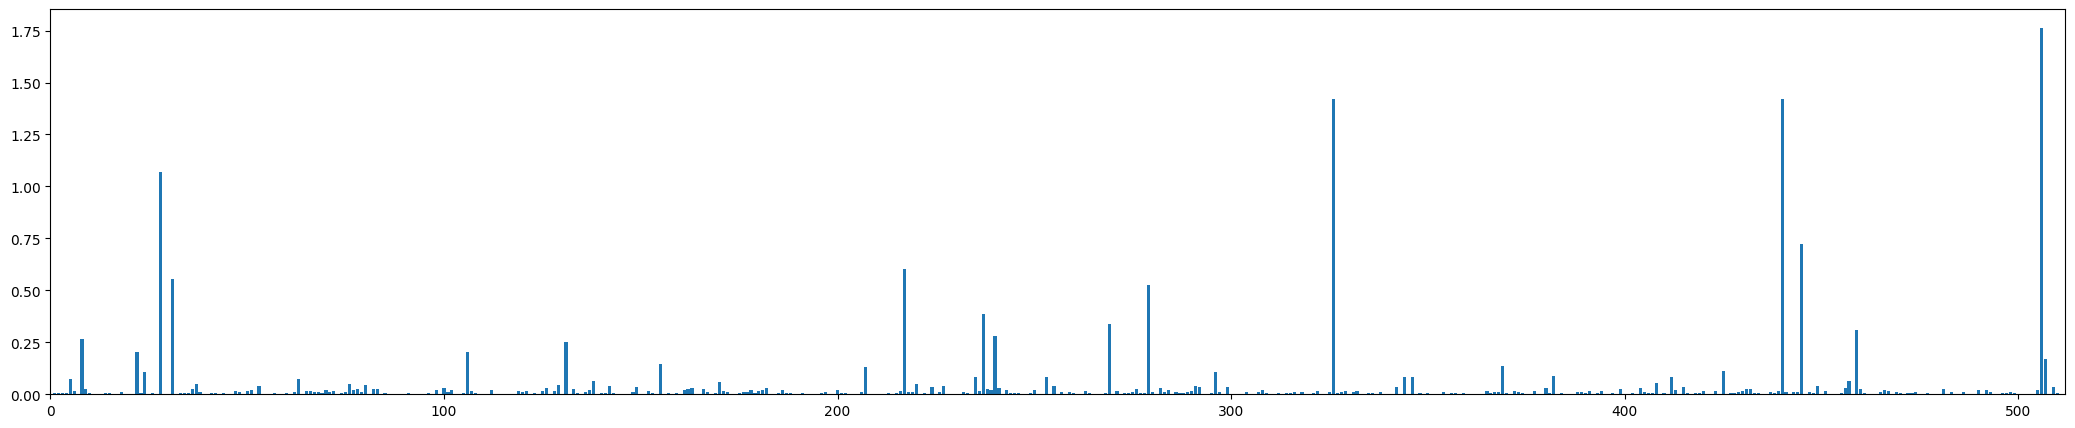

In [6]:
bar_chart(z_1_single_timeframe)
bar_chart(z_2_single_timeframe)

bar_chart(elemwise_multipl, savename=f"{type}_{nb_dims}_{z1_file}_to_{z2_file}_most_important_dims") # highest values are the most important

# NOW USING DECODER WHICH LEARNED TO MINIMIZE RECONSTRUCTION OF SIGNALS IN TIME DOMAIN.
Before was decoder that minimized reconstruction of mel-spectrograms. 

Let's use 1 GPUs!
Loading weights from  ./sim_logs//full_pipeline_bart/audio_FULL_PIPELINE_sim_de_boer_SIM=trueKLD=0.01
DataParallel(
  (module): FullModel(
    (fullmodel): ModuleList(
      (0): IndependentModule(
        (encoder): CNNEncoder(
          (encoder): Sequential(
            (layer 0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), padding=(2,))
              (1): ReLU()
            )
            (layer 1): Sequential(
              (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), padding=(2,))
              (1): ReLU()
            )
          )
          (encoder_mu): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
          (encoder_var): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
        )
        (loss): InfoNCE_Loss(
          (predictor): Linear(in_features=512, out_features=6144, bias=False)
          (loss): LogSoftmax(dim=1)
        )
      )
      (1): IndependentModule(
        (encoder): CNNEncoder(
          (encoder)

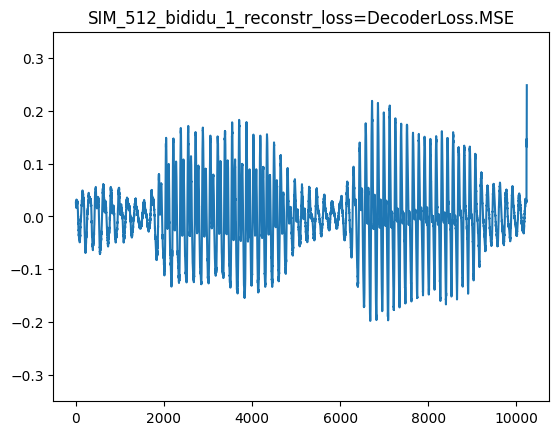

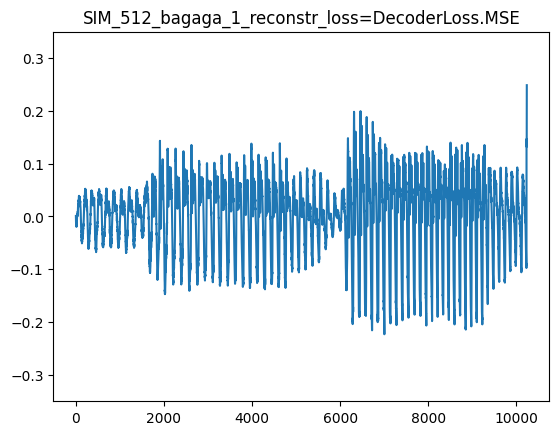

In [7]:
from config_code.config_classes import DecoderLoss

get_options = create_get_options_func(nb_dims, type)
opt: OptionsConfig = get_options()
opt.decoder_config.decoder_loss = DecoderLoss.MSE

context_model, decoder = _get_models(opt)

_, _, z, filenames = _get_data(opt, context_model, decoder)
print_z_names(filenames)
# z1, z2, z1_file, z2_file = get_two_zs(z, filenames, 27, 15)  # 27 = bibibi_1, 15 = bagaga_1
z1, z2, z1_file, z2_file = get_two_zs(z, filenames, 36, 15)  # 36 = bididu_1, 15 = bagaga_1
# z1, z2, z1_file, z2_file = get_two_zs(z, filenames, 0, 19)  # 0 = babadu_1, 1 = bagubi_1

audio(z1)
audio(z2)

plot(z1, savename=f"{type}_{nb_dims}_{z1_file}_reconstr_loss={opt.decoder_config.decoder_loss}")
plot(z2, savename=f"{type}_{nb_dims}_{z2_file}_reconstr_loss={opt.decoder_config.decoder_loss}")

In [8]:
interpolations = interpolate(z1, z2, 10)
print(f"Interpolating between {z2_file} and {z1_file}")
for z in interpolations:
    audio(z)

Interpolating between bagaga_1 and bididu_1


In [9]:
# ********************************************************************************************************************
# CHOOSE HOW MANY DIMENSIONS WILL BE CHANGED.
# PLAY AROUND WITH THIS VALUE. Observe that GIM NEEDS MORE DIMENSIONS TO CHANGE THAN SIM, implying that GIM's information is more spread out. (SIM's information is more concentrated in fewer dimensions)
nb_most_important_dims = 32  # val between 1 and 512
assert nb_most_important_dims <= nb_dims
# ********************************************************************************************************************

# mean
z_1_single_timeframe = z1.mean(axis=2)  # (1, 32)
z_2_single_timeframe = z2.mean(axis=2)  # (1, 32)
elemwise_multipl = abs(
    z_1_single_timeframe * z_2_single_timeframe)  # most important dimensions based on elementwise multiplication of z1.mean and z2.mean, where z1.ean and z2.mean are vectors of size 512 (or 32 in smaller architecture)

# Objective: start from z_digibi and go to z_gabaga, but only change the 10 important dimensions (based on var: `elemwise_multipl)
# 1. get the 10 most important dimensions
dims = np.argsort(elemwise_multipl.squeeze())[::-1][:nb_most_important_dims]  # in descending order

# 2. start from z_digibi and go to z_gabaga, but only change the 10 important dimensions
zs = interpolate_partial(z1, z2, dims, 10)
print(
    f"Interpolating between {z2_file} and {z1_file} but only changing the {nb_most_important_dims} most important dimensions")
for z in zs:
    audio(z)

Interpolating between bagaga_1 and bididu_1 but only changing the 32 most important dimensions


Target:


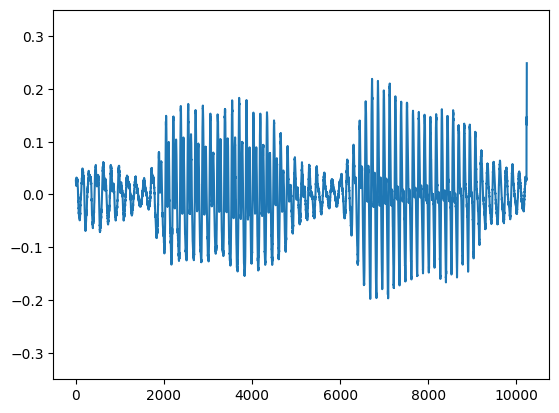

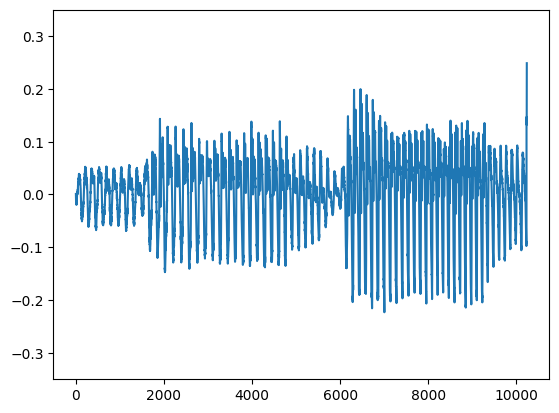

Interpolated with partial dimensions:
eg 32 dims: We observe little to no change in GIM, but a lot of change in SIM


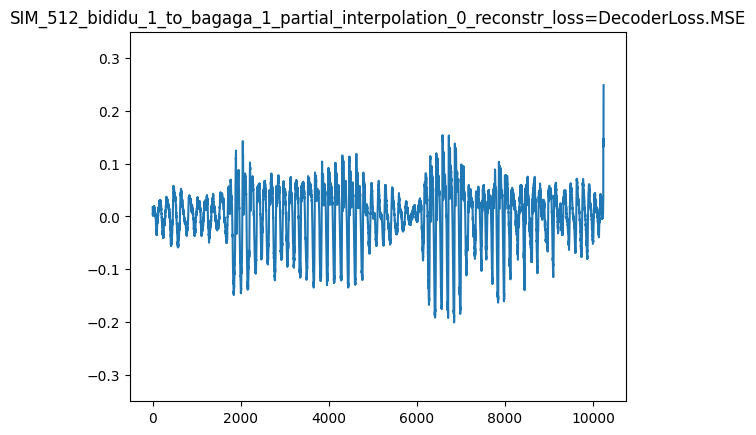

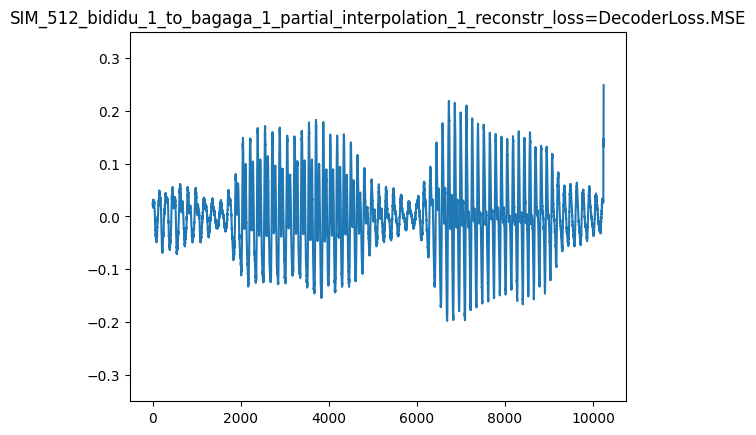

In [10]:
print("Target:")
plot(z1)
plot(z2)

print("Interpolated with partial dimensions:")
print("eg 32 dims: We observe little to no change in GIM, but a lot of change in SIM")
plot(zs[0],
     savename=f"{type}_{nb_dims}_{z1_file}_to_{z2_file}_partial_interpolation_0_reconstr_loss={opt.decoder_config.decoder_loss}")
plot(zs[-1],
     savename=f"{type}_{nb_dims}_{z1_file}_to_{z2_file}_partial_interpolation_1_reconstr_loss={opt.decoder_config.decoder_loss}")

Plotting different PARTIAL interpolations


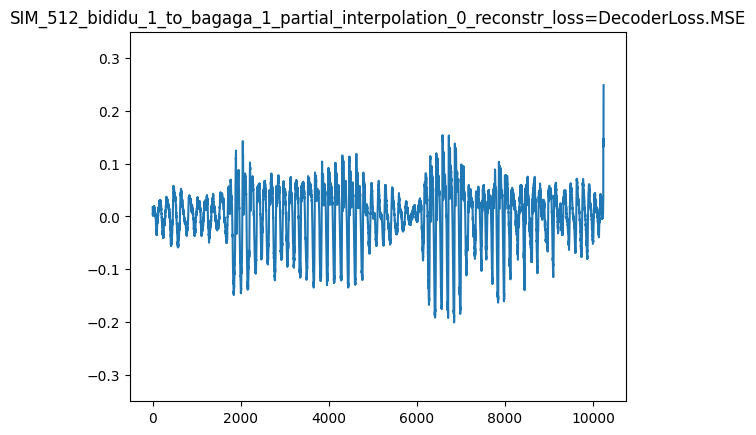

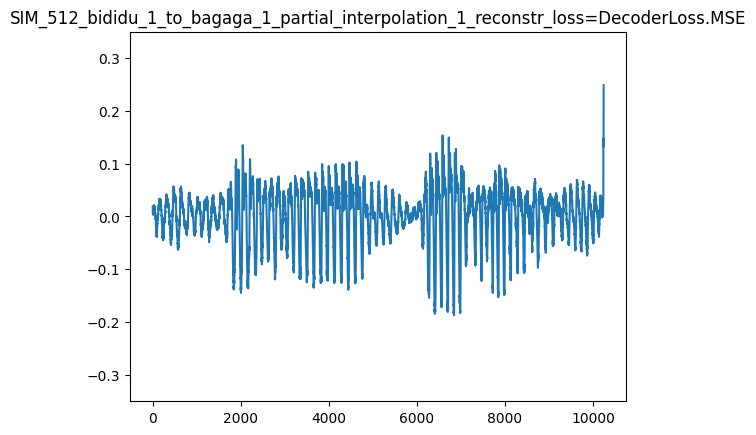

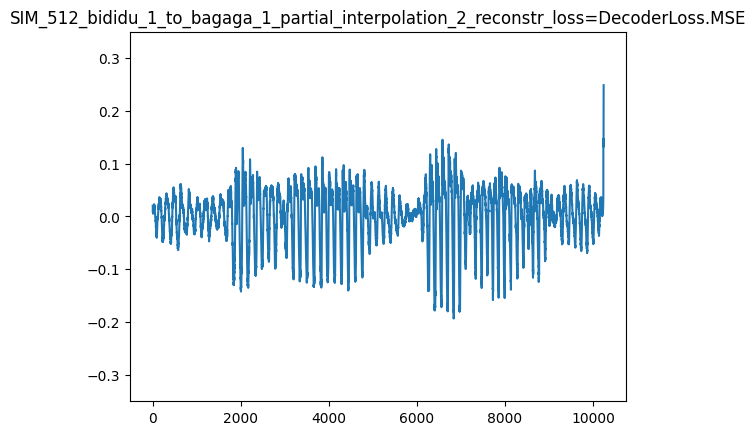

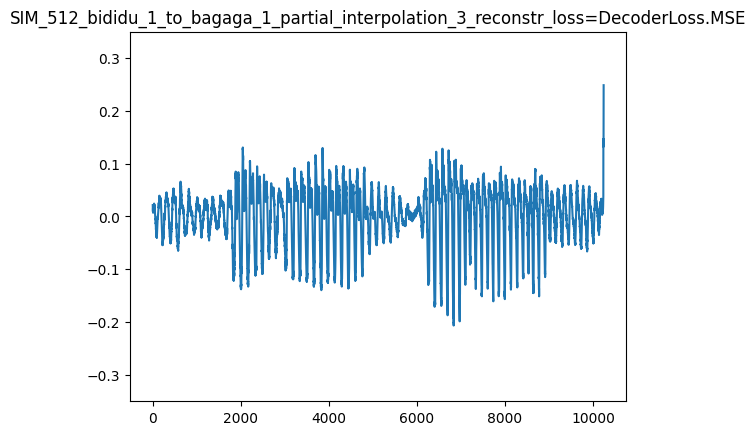

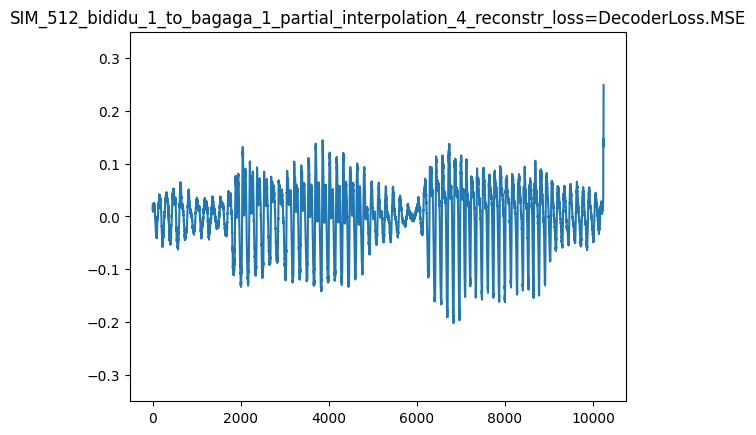

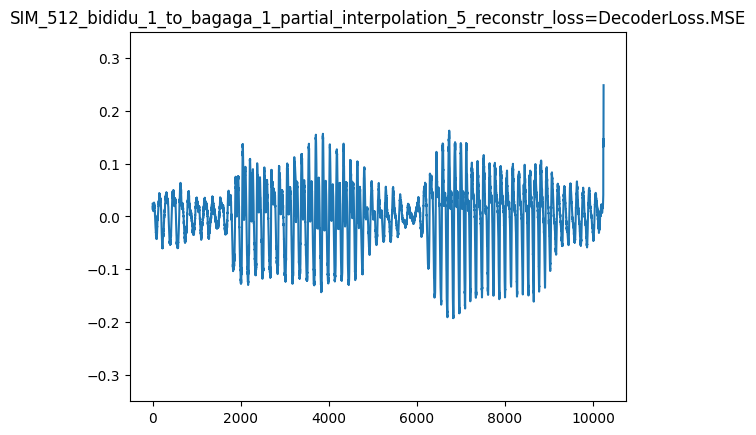

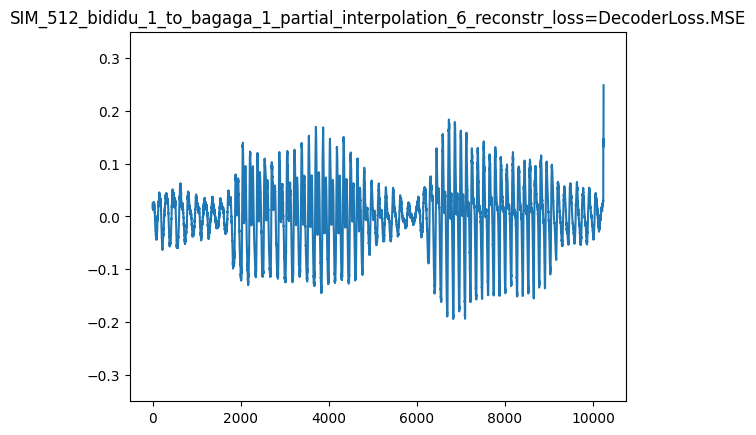

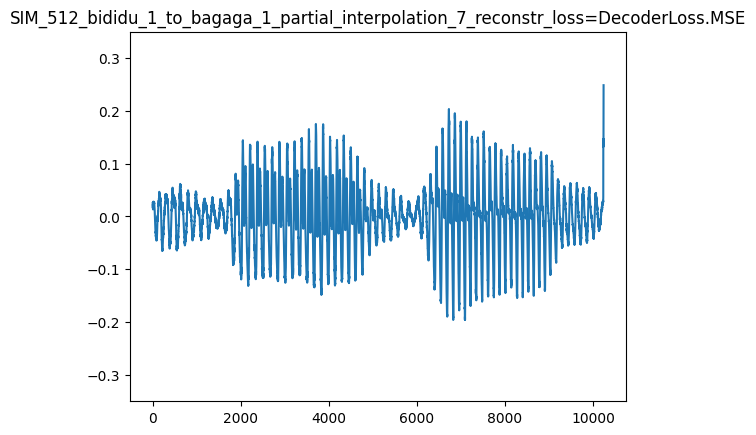

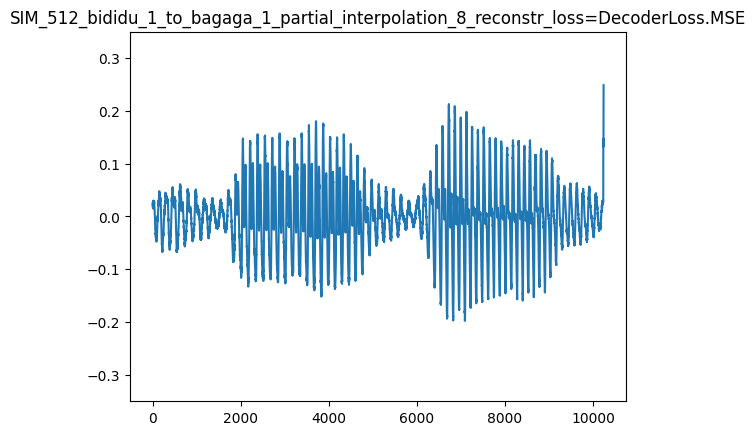

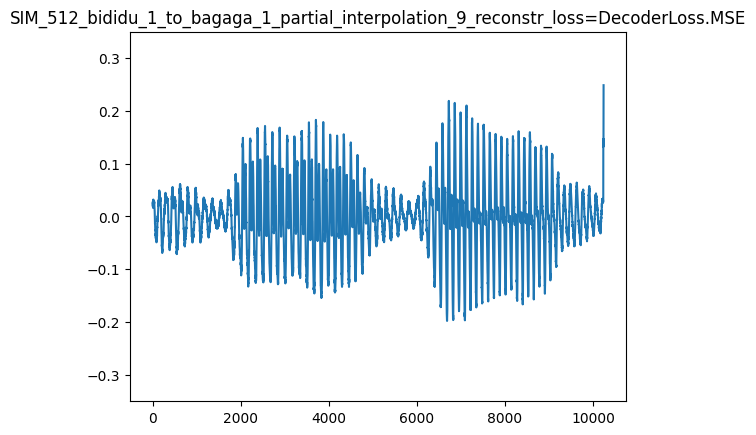

In [11]:
print("Plotting different PARTIAL interpolations")
for idx, z in enumerate(zs):
    plot(z,
         savename=f"{type}_{nb_dims}_{z1_file}_to_{z2_file}_partial_interpolation_{idx}_reconstr_loss={opt.decoder_config.decoder_loss}")

Plotting different FULL interpolations


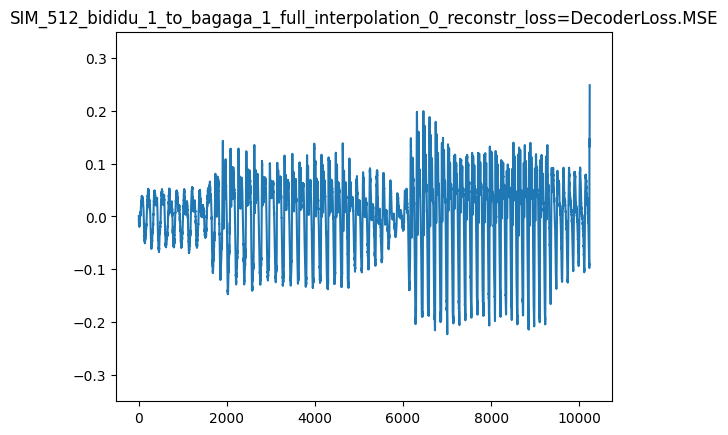

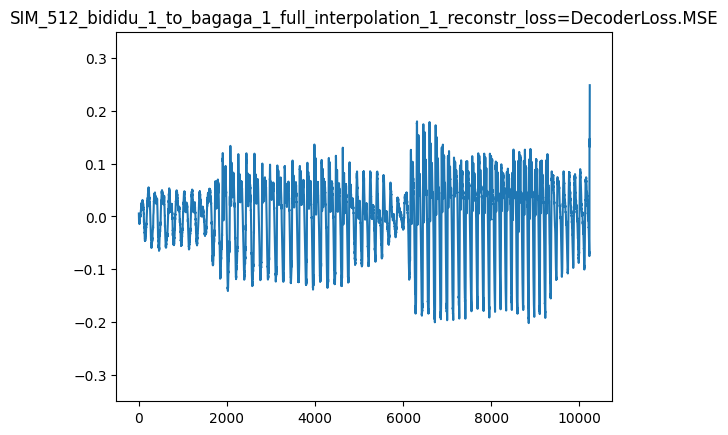

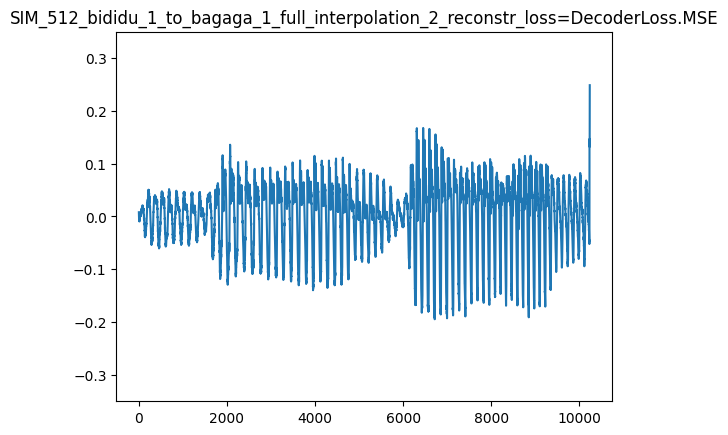

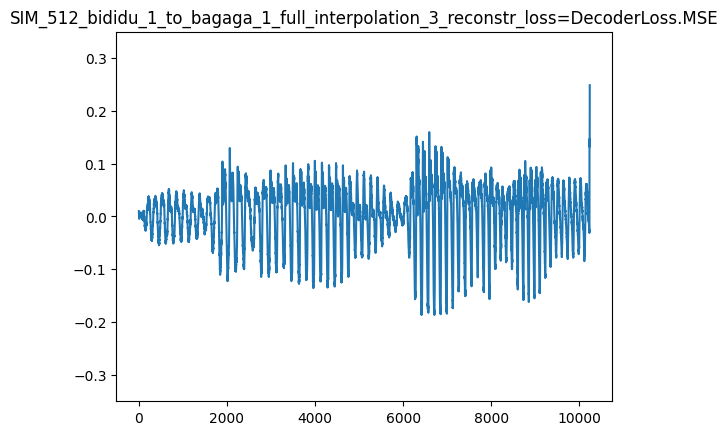

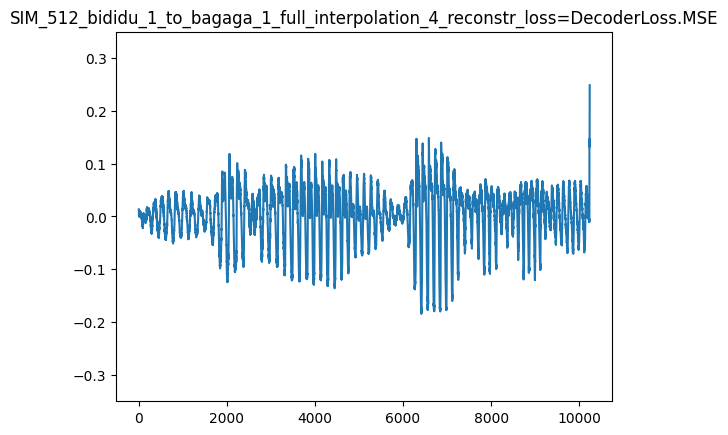

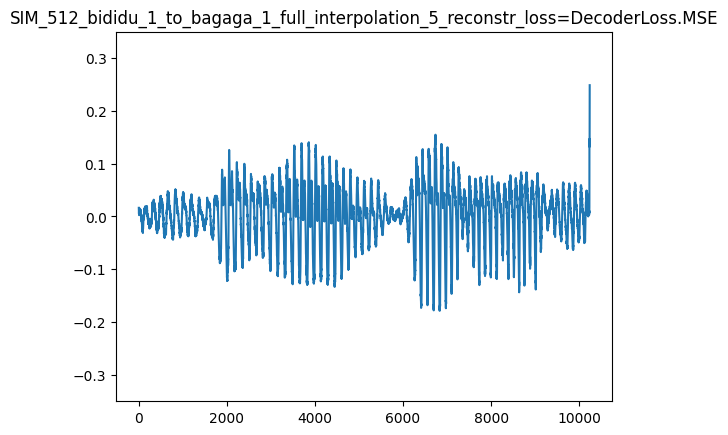

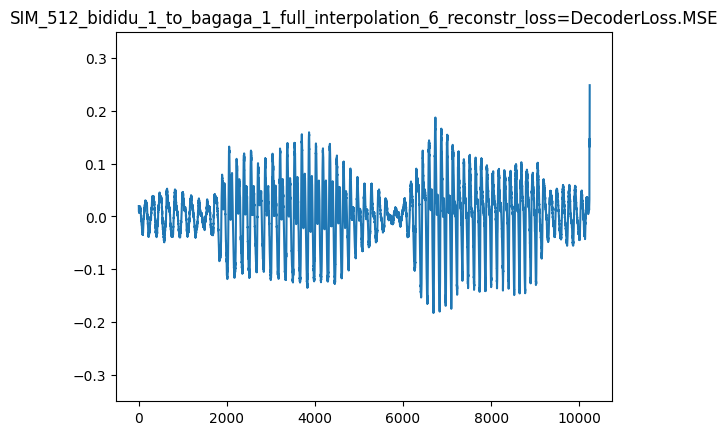

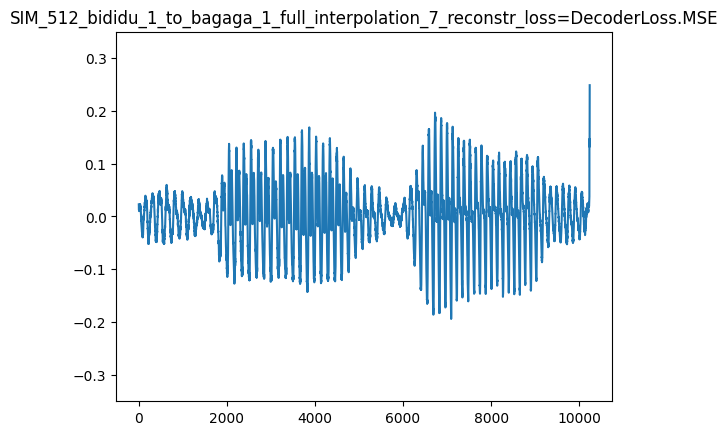

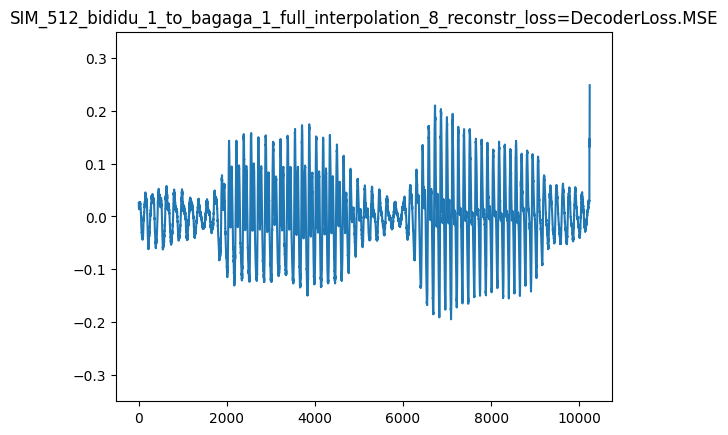

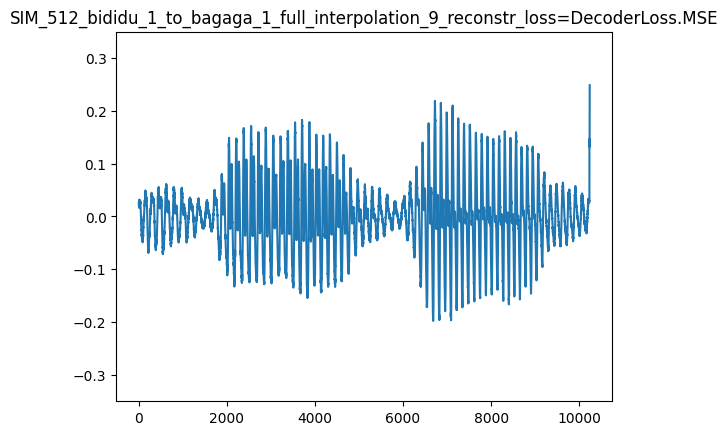

In [12]:
print("Plotting different FULL interpolations")
for idx, z in enumerate(interpolations):
    plot(z,
         savename=f"{type}_{nb_dims}_{z1_file}_to_{z2_file}_full_interpolation_{idx}_reconstr_loss={opt.decoder_config.decoder_loss}")